# Uber Analysis

In [1]:
#Import required libraries

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

Read the downloaded csv file into DataFrame called `masterdf`

In [2]:
masterdf = pd.read_csv("Uber Request Data.csv")

#Lets have a prelimanary look at the dataset
masterdf.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [3]:
#Lets also have a look at the dataset with respect to properties of its columns
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB


We can observe that there are **6745 Rows** and **6 Columns**. `Request id` is correctly readed as int. `Pickup point` is readed as object whereas more suitable datatype for it is category since it has only 2 category i.e. Airport and City. `Driver id` have few null values and hence its readed as float rather than int. `Status` like Pickup point should be categorical. `Request timestamp` and `Drop timestamp` should be in datetime format rather than object so that they can be used to perform datetime operations.

In [4]:
#lets make the required changes
masterdf['Pickup point'] = masterdf['Pickup point'].astype('category')
masterdf = masterdf.drop(columns=['Driver id', 'Drop timestamp'])
masterdf['Status'] = masterdf['Status'].astype('category')
masterdf['Request timestamp'] = pd.to_datetime(masterdf['Request timestamp'])

#lets have a look at df info again
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 4 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null category
Status               6745 non-null category
Request timestamp    6745 non-null datetime64[ns]
dtypes: category(2), datetime64[ns](1), int64(1)
memory usage: 118.8 KB


## 1. Visually identify the most pressing problems for Uber.  

To properly utilize `Request timestamp`, we will use a category variable which represents `Part of day` which has values - Night(0hr-6hr), Morning(6hr-12hr), Afternoon(12hr-18hr) and Evening(18hr-24hr).

In [5]:
#Using pd.cut, we'll make groups in series with custom labels
session = pd.cut(masterdf['Request timestamp'].dt.hour,[-1,5,11,17,23], \
                 labels=['Night','Morning','Afternoon','Evening'])
masterdf = masterdf.assign(PartofDay=session)
masterdf['PartofDay'] = masterdf['PartofDay'].astype('category')
masterdf.head()

,Request id,Pickup point,Status,Request timestamp,PartofDay
0,619,Airport,Trip Completed,2016-11-07 11:51:00,Morning
1,867,Airport,Trip Completed,2016-11-07 17:57:00,Afternoon
2,1807,City,Trip Completed,2016-12-07 09:17:00,Morning
3,2532,Airport,Trip Completed,2016-12-07 21:08:00,Evening
4,3112,City,Trip Completed,2016-07-13 08:33:16,Morning


Now lets plot the count of rides against all categorical variables that we have i.e. `Status`, `Pickup point` and `PartofDay`.

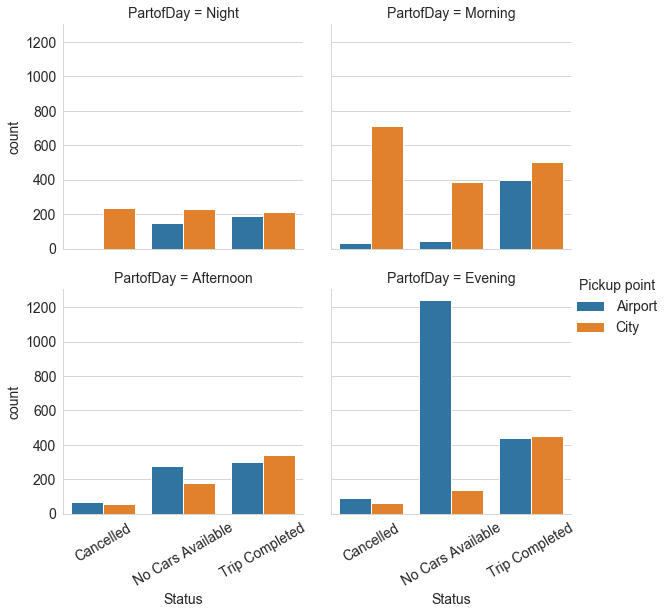

In [6]:
matplotlib.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')
sns.set_style('whitegrid')
ax = sns.catplot(x='Status', hue='Pickup point', col='PartofDay', data=masterdf, kind='count', \
                 height=4, aspect=1, col_wrap=2)
ax.set_xticklabels(rotation=30)

Let address the most prominent observations and inferences - 
1. There is huge spike in the `Evening`(18hr-24hr) which shows `No cars Available` when the Pickup point is `Airport`. This could be due to arrival of flights in this part of the day hence surging the demand but this demand is not met by available drivers and customers face No cars Available problem.<hr>

2. Next interesting spike is in `Morning`(6hr-12hr) which shows `Cancelled` when the Pickup point is `City`. Now this could be due to the absence of arrival of many flights in Morning hence there is no demand at the airport and drivers need to wait for longer time to get a ride from airport which is economically inconvenient for them hence they cancel the ride from the City to Airport in the first place.<hr>

3. Another evidence for the above hypothesis are the spikes in `Morning` which shows `No cars Available` when the Pickup point is `City`. This shows that most drivers prefer destinations other than Airport and are occupied with the same. 

## 2. Find out the gap between supply and demand and show the same using plots.

For this task we'll create a new categorical variable called `Gap` which represent weather there was a gap in supply and demand or the trip was completed successfully.

In [7]:
masterdf['Gap'] = masterdf['Status'].apply(lambda x : x!='Trip Completed')
masterdf.head()

,Request id,Pickup point,Status,Request timestamp,PartofDay,Gap
0,619,Airport,Trip Completed,2016-11-07 11:51:00,Morning,False
1,867,Airport,Trip Completed,2016-11-07 17:57:00,Afternoon,False
2,1807,City,Trip Completed,2016-12-07 09:17:00,Morning,False
3,2532,Airport,Trip Completed,2016-12-07 21:08:00,Evening,False
4,3112,City,Trip Completed,2016-07-13 08:33:16,Morning,False


To understand the supply-demand `Gap` with respect to `PartofDay`, lets plot the percentage of rides that were successfully completed.

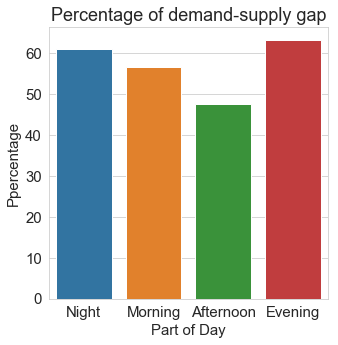

In [8]:
portofday_gap = (masterdf.groupby('PartofDay')['Gap'].sum()/masterdf['PartofDay'].value_counts())*100
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(5, 5))
plt.title('Percentage of demand-supply gap')
plt.xlabel('Part of Day')
plt.ylabel('Ppercentage')
sns.set_style('whitegrid')
ax = sns.barplot(portofday_gap.index, portofday_gap.values)

Let address the most prominent observations and inferences - 
1. The highest peak is in the `Evening`(18hr-24hr) as there is a huge demand generated at the airport at this time and customers face `No cars Available` hence creating the gap and more than 60% of trips are not met with supply.<hr>
2. The second highest peak is in `Night`(0hr-6hr) as the trend from evening continues. Also number of drivers decreases in the night and the places which they travel to, gets limited and increasing the demand-supply gap.

## 3. Recommend some ways to resolve the supply-demand gap.

- First of all, clearly airport rides are different from other intracity rides as the demand and supply is governed by the arrival and departure of flights. This arrival and departure has a specific pattern rather than random requests for rides.<hr>

- The flight patterns could be studied to provide better customer service.<hr>

- There is huge demand in the evening due to arrival of flights. Drivers can be provided with incentives to accept such rides or a special unit of drivers can be appointed which serves passengers only from and to airport.<hr>

- Drivers can also be provided with incentives to accept rides to airport in the morning time if they doesn't receive a ride request for a specific amount of time. This will help reduce the economical disadvantage drivers face when they return without passengers from airport.<hr>

- Passengers could be prioritised based on weather they are willing to pay extra for earlier access to a cab at peak times.  